Vector unary operations
=======================


In [1]:
Boyle.activate("project-numy")

Resolving Hex dependencies...
Dependency resolution completed:
Unchanged:
  flow 0.15.0
  gen_stage 0.14.3
  gnuplot 1.19.96
  numy 0.1.4
All dependencies are up to date
make: Nothing to be done for 'all'.


:ok

## Negate, scale and offset

In [2]:
alias Numy.Vc
alias Numy.Vcm
alias Numy.Lapack, as: La

v = La.Vector.new(-3..3) # let's create vector with values from -3 to 3
Vc.data(v)

[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0]

We can change sign of each element in-place with `Vcm.negate!`.

In [3]:
v = La.Vector.new(-3..3)
Vcm.negate!(v)
v

#Vector<size=7, [3.0, 2.0, 1.0, 0.0, -1.0, -2.0, -3.0]>

Or we can use `Vc` protocol and do not mutate the state of the
original vector (copies are created).

In [4]:
v = La.Vector.new(-3..3)
vneg = Vc.negate(v)

#Vector<size=7, [3.0, 2.0, 1.0, 0.0, -1.0, -2.0, -3.0]>

We can add some constant to all elements.

In [5]:
vsh = Vc.offset(v, 0.5)

#Vector<size=7, [-2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5]>

We can multiply each element of a vector by a constant factor.

In [6]:
vm = Vc.scale(v, 2)

#Vector<size=7, [-6.0, -4.0, -2.0, 0.0, 2.0, 4.0, 6.0]>

Let us plot all these vectors as they are segments of some lines. This way the transformations get visual representation.

In [7]:
defmodule TerminalOutput do
  def capture(out \\ <<>>) do
    receive do
      {_, {:data, data}} ->
        capture(out <> data)
      {_, :closed} ->
        out
    after
      1_000 ->
        out
    end
  end
end

{:module, TerminalOutput, <<70, 79, 82, 49, 0, 0, 5, 252, 66, 69, 65, 77, 65, 116, 85, 56, 0, 0, 0, 161, 0, 0, 0, 17, 21, 69, 108, 105, 120, 105, 114, 46, 84, 101, 114, 109, 105, 110, 97, 108, 79, 117, 116, 112, 117, 116, 8, ...>>, {:capture, 1}}

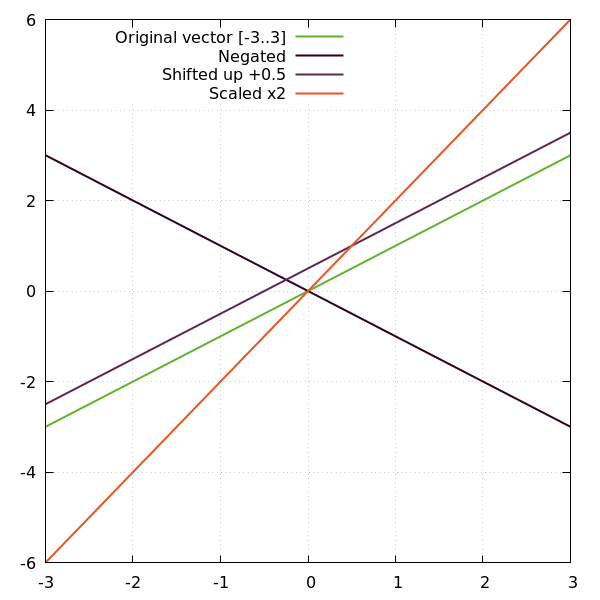

In [25]:
points = [-3,-2,-1,0,1,2,3]
datasets = for ds <- [Vc.data(v),Vc.data(vneg),Vc.data(vsh),Vc.data(vm)], do:
  Enum.zip(points, ds)

Gnuplot.plot([
  ~w(set terminal pngcairo size 600,600)a,
  ~w(set output)a,
  ~w(set key left top)a,
  ~w(set grid xtics ytics)a,
  ~w(set style line 1 lw 2 lc '#63b132')a,
  ~w(set style line 2 lw 2 lc '#2C001E')a,
  ~w(set style line 3 lw 2 lc '#5E2750')a,
  ~w(set style line 4 lw 2 lc '#E95420')a,
  Gnuplot.plots([
    ["-", :title, "Original vector [-3..3]", :with, :lines, :ls, 1],
    ["-", :title, "Negated", :with, :lines, :ls, 2],
    ["-", :title, "Shifted up +0.5", :with, :lines, :ls, 3],
    ["-", :title, "Scaled x2", :with, :lines, :ls, 4],
  ])
  ],
  datasets
)

TerminalOutput.capture() |> Base.encode64 |> IO.write
:"this is an inline image"

## Change order of elements with `reverse` and `sort`

In [47]:
v = La.Vector.new(10) # create a vector with 10 elements
v |> Vc.assign_random |> Vcm.scale!(10) # assign random values to all elements

#Vector<size=10, [9.445983680837887, 4.165549645134661, 2.6357005286131585, 6.491221763790412, 0.17086130323450077, 8.909500701692739, 0.20224513665443422, 7.781593675407348, 1.363862762495317, 7.928549809561595]>

In [48]:
v |> Vcm.reverse! # reverse in-place

#Vector<size=10, [7.928549809561595, 1.363862762495317, 7.781593675407348, 0.20224513665443422, 8.909500701692739, 0.17086130323450077, 6.491221763790412, 2.6357005286131585, 4.165549645134661, 9.445983680837887]>

In [49]:
v |> Vcm.sort!

#Vector<size=10, [0.17086130323450077, 0.20224513665443422, 1.363862762495317, 2.6357005286131585, 4.165549645134661, 6.491221763790412, 7.781593675407348, 7.928549809561595, 8.909500701692739, 9.445983680837887]>

## Apply simple filters, step function and sigmoid.

In [52]:
v = La.Vector.new(10)
v |> Vc.assign_random
v |> Vcm.offset!(-0.5) # shift down by 0.5 so we get negative values
step = v |> Vc.apply_heaviside

#Vector<size=10, [0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0]>

In [53]:
sgm = v |> Vc.apply_sigmoid

#Vector<size=10, [0.4340130902802231, 0.5078088734118038, 0.5573929819736723, 0.46135323237181214, 0.5780261960746852, 0.5353252812865444, 0.5110320710257269, 0.5198110819693998, 0.38410068404116865, 0.41411182467672863]>

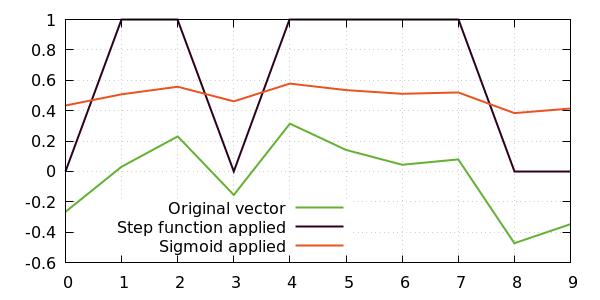

In [59]:
points = Enum.to_list(0..9)
datasets = for ds <- [Vc.data(v),Vc.data(step),Vc.data(sgm)], do:
  Enum.zip(points, ds)

Gnuplot.plot([
  ~w(set terminal pngcairo size 600,300)a,
  ~w(set output)a,
  ~w(set key left bottom)a,
  ~w(set grid xtics ytics)a,
  ~w(set style line 1 lw 2 lc '#63b132')a,
  ~w(set style line 2 lw 2 lc '#2C001E')a,
  ~w(set style line 3 lw 2 lc '#E95420')a,
  Gnuplot.plots([
    ["-", :title, "Original vector", :with, :lines, :ls, 1],
    ["-", :title, "Step function applied", :with, :lines, :ls, 2],
    ["-", :title, "Sigmoid applied", :with, :lines, :ls, 3]
  ])
  ],
  datasets
)

TerminalOutput.capture() |> Base.encode64 |> IO.write
:"this is an inline image"